In [230]:
# Brazil-Elections-Twitter-Sentiment 

# Twitter Sentiment Analysis using sklearn (Under Review)

# Description:
#- Program that collects data from Twitter API and classify it into sentiment categories based on positive and negative Amazon reviews
# Model Type 
### Ensemble Model - Decision Tree Classifier, Logistic Regression, Random Forest, KNN
#20/10/2022

# Version - V1.3

# Goals:
#- To build a ML model that is able to predict the sentiment from twitter hashtags, posts and profiles

# Key Insights and Notes
#- Since this is an Election sentiment prediction, values can be affect everyday by new information
#- The ensemble model was able to improve the accuracy by 5% comparing it to the previous model 
#- An ensemble model is not necessary better than any other model, you should be able to read the results and pick the best model
#- Repeated tweets might be affecting the performance, you can choose to remove it 
#- Hyperparameters Optimization was not done yet 
 
# Fixes
#- Translation to Portuguese Added


# Version Updates:
#- Ensemble Model added
#- API connections
#- Classify by hashtags
#- Sklearn implemented 
#- Amazon reviews database
#- Save the model 
#- Statistics
#- Added sentiment database
#- Comparisons added 
#- Language translation added
#- Remove duplicates 


# Future Implementations: 
#- Plot Analytical charts 
#- Add start_time and end_time parameters
#- Create a list with market symbol and their sentiment
#- Add time period analysis(select period option)
#- Create sentiment dictionaries from web studies 
#- Hyperparameters Optimization 
#- Train and test with the Brazilian dataset
#- Analyze use of prepositions 
#- Create a Market Checker were it indicates the sentiment on the period and Prints the Chart Bullish or Bearish 

# Author - Luiz Gabriel Bongiolo

# Credits & References 
#- https://developer.twitter.com/en/docs/tutorials/five-ways-to-convert-a-json-object-to-csv
#- https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets
#- Computer Science youtube channel - https://www.youtube.com/watch?v=ujId4ipkBio&t=280s
#- Keith Galli - https://www.youtube.com/watch?v=M9Itm95JzL0
#- http://jmcauley.ucsd.edu/data/amazon/
#- Daniel Ellis Research - https://towardsdatascience.com/language-translation-using-python-bd8020772ccc
#- Leandro Guerra - https://www.outspokenmarket.com/ - Instagram @leandrowar

In [231]:
#Import Libraries 

import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
plt.style.use("fivethirtyeight")
import os

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import warnings
warnings.filterwarnings("ignore")




In [232]:
#Data Class

import random

class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        

In [233]:
import json

file_name = './Twitter Sentiment Analysis/ML Sentiment Analysis/data/sentiment/Books_small_10000.json'

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))
        
reviews[5].text

'I hoped for Mia to have some peace in this book, but her story is so real and raw.  Broken World was so touching and emotional because you go from Mia\'s trauma to her trying to cope.  I love the way the story displays how there is no "just bouncing back" from being sexually assaulted.  Mia showed us how those demons come for you every day and how sometimes they best you. I was so in the moment with Broken World and hurt with Mia because she was surrounded by people but so alone and I understood her feelings.  I found myself wishing I could give her some of my courage and strength or even just to be there for her.  Thank you Lizzy for putting a great character\'s voice on a strong subject and making it so that other peoples story may be heard through Mia\'s.'

In [234]:
#Prepare the data

from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size=0.2, random_state=21)

train_container = ReviewContainer(training)

test_container = ReviewContainer(test)

In [235]:
train_container.evenly_distribute()
x_train = train_container.get_text()
y_train = train_container.get_sentiment()

test_container.evenly_distribute()
x_test = test_container.get_text()
y_test = test_container.get_sentiment()

print(y_train.count(Sentiment.POSITIVE))
print(y_train.count(Sentiment.NEGATIVE))

525
525


In [236]:
#Words vectorization

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# This book is great !
# This book was so bad

vectorizer = TfidfVectorizer()
x_train_vectors = vectorizer.fit_transform(x_train)

x_test_vectors = vectorizer.transform(x_test)

print(x_train[0])
print(x_train_vectors[0].toarray())

This third book in the series could not begin to compare with the first two. It seemed to have a negative aura about it which I did not enjoy. Also the last few pages with all the fantasy descriptions were just too much--way over the top and very ridiculous--not the author's normal style at all. I thought that it was a terrible finale to a less than the best book and am certainly hoping that the following books in this series are much better than this one!
[[0. 0. 0. ... 0. 0. 0.]]


In [237]:
#Creating multiple models to train

models = [
                ("Emod1", DecisionTreeClassifier(max_depth = 3, random_state = 42))
                , ("Emod2", LogisticRegression(random_state = 42))
                , ("Emod3", DecisionTreeClassifier(max_depth = 8, random_state = 42))
            ]

mod1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
mod2 = LogisticRegression(random_state = 42)
mod3 = DecisionTreeClassifier(max_depth = 8, random_state = 42)

mod1.fit(x_train_vectors, y_train) 
mod2.fit(x_train_vectors, y_train) 
mod3.fit(x_train_vectors, y_train) 

ensemble_hard = VotingClassifier(models, voting = "hard")
ensemble_soft = VotingClassifier(models, voting = "soft")
ensemble_stacking = StackingClassifier(models, LogisticRegression(random_state = 42), passthrough = False)
ensemble_stacking_pt = StackingClassifier(models, LogisticRegression(random_state = 42), passthrough = True)

ensemble_hard.fit(x_train_vectors, y_train)
ensemble_soft.fit(x_train_vectors, y_train)
ensemble_stacking.fit(x_train_vectors, y_train)
ensemble_stacking_pt.fit(x_train_vectors, y_train)

print("Mod1:     {}".format(round(accuracy_score(y_test,mod1.predict(x_test_vectors))*100, 2)))
print("Mod2:     {}".format(round(accuracy_score(y_test,mod2.predict(x_test_vectors))*100, 2)))
print("Mod3:     {}".format(round(accuracy_score(y_test,mod3.predict(x_test_vectors))*100, 2)))
print("Hard Voting: {}".format(round(accuracy_score(y_test,ensemble_hard.predict(x_test_vectors))*100, 2)))
print("Soft Voting: {}".format(round(accuracy_score(y_test,ensemble_soft.predict(x_test_vectors))*100, 2)))
print("Stacking: {}".format(round(accuracy_score(y_test,ensemble_stacking.predict(x_test_vectors))*100, 2)))
print("Stacking - passthrough: {}".format(round(accuracy_score(y_test,ensemble_stacking_pt.predict(x_test_vectors))*100, 2)))

Mod1:     66.39
Mod2:     86.13
Mod3:     70.17
Hard Voting: 73.11
Soft Voting: 72.27
Stacking: 86.97
Stacking - passthrough: 86.13


In [238]:
# F1 Scores
from sklearn.metrics import f1_score

f1_score(y_test, ensemble_stacking.predict(x_test_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])
#f1_score(test_y, ensemble_stacking.predict(x_test_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])




array([0.86462882, 0.87449393])

In [239]:
#Test with your own words

test_set = ['I love this book', "bad book do not buy", 'horrible waste of time', 'I hate this guy']
new_test = vectorizer.transform(test_set)

ensemble_stacking.predict(new_test)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE'], dtype='<U8')

In [242]:
# Stacking Multi layers - 2 Layers

# Layers, simulating a neural network 
layer1 = models
layer2 = [
                 ("Emod4", DecisionTreeClassifier(max_depth = 5, random_state = 42))
                ,("Emod5", RandomForestClassifier(n_estimators = 10, random_state = 42))
                ,("Emod6", KNeighborsClassifier(n_neighbors = 10))
                       ]

ensemble_c2 = StackingClassifier(layer2, final_estimator = LogisticRegression(random_state = 42), passthrough = True)
ensemble_multi = StackingClassifier(layer1, final_estimator = ensemble_c2, passthrough = True)

ensemble_multi.fit(x_train_vectors, y_train)

print("Stacking - Multi layer: {}".format(round(accuracy_score(y_test,ensemble_multi.predict(x_test_vectors))*100, 2)))

Stacking - Multi layer: 83.19


In [243]:
# Using layers, simulating a neural network 

layer1 = models
layer2 = [
                 ("Emod4", LogisticRegression(random_state = 42))
                ,("Emod5", RandomForestClassifier(n_estimators = 5, random_state = 42))
                ,("Emod6", KNeighborsClassifier(n_neighbors = 5))
                       ]
layer3 = [
                 ("Emod7", LogisticRegression(random_state = 42))
                ,("Emod8", KNeighborsClassifier(n_neighbors = 15))
                ,("Emod9", KNeighborsClassifier(n_neighbors = 5))
                  ]

ensemble_c3 = StackingClassifier(layer3, final_estimator = LogisticRegression(random_state = 42), passthrough = True)
ensemble_c2 = StackingClassifier(layer2, final_estimator = ensemble_c3, passthrough = True)

ensemble_multi3 = StackingClassifier(layer1, final_estimator = ensemble_c2, passthrough = True)

ensemble_multi3.fit(x_train_vectors, y_train)

print("Stacking - Multi Layer 3:  {}".format(round(accuracy_score(y_test,ensemble_multi3.predict(x_test_vectors))*100, 2)))


Stacking - Multi Layer 3:  85.71


In [244]:
#Report with all the results to understand the stability of the models we tested

print("Mod1 Train:        {}".format(round(accuracy_score(y_train,mod1.predict(x_train_vectors))*100, 2)))
print("Mod1 Test:         {}".format(round(accuracy_score(y_test,mod1.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,mod1.predict(x_train_vectors))/accuracy_score(y_test,mod1.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Mod2 Train:        {}".format(round(accuracy_score(y_train,mod2.predict(x_train_vectors))*100, 2)))
print("Mod2 Test:         {}".format(round(accuracy_score(y_test,mod2.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,mod2.predict(x_train_vectors))/accuracy_score(y_test,mod2.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Mod3 Train:        {}".format(round(accuracy_score(y_train,mod3.predict(x_train_vectors))*100, 2)))
print("Mod3 Test:         {}".format(round(accuracy_score(y_test,mod3.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,mod3.predict(x_train_vectors))/accuracy_score(y_test,mod3.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Hard Voting Train: {}".format(round(accuracy_score(y_train,ensemble_hard.predict(x_train_vectors))*100, 2)))
print("Hard Voting Test:  {}".format(round(accuracy_score(y_test,ensemble_hard.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_hard.predict(x_train_vectors))/accuracy_score(y_test,ensemble_hard.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Soft Voting Train: {}".format(round(accuracy_score(y_train,ensemble_soft.predict(x_train_vectors))*100, 2)))
print("Soft Voting Test:  {}".format(round(accuracy_score(y_test,ensemble_soft.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_soft.predict(x_train_vectors))/accuracy_score(y_test,ensemble_soft.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Stacking Train:    {}".format(round(accuracy_score(y_train,ensemble_stacking.predict(x_train_vectors))*100, 2)))
print("Stacking Test:     {}".format(round(accuracy_score(y_test,ensemble_stacking.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_stacking.predict(x_train_vectors))/accuracy_score(y_test,ensemble_stacking.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Stacking - passthrough Train: {}".format(round(accuracy_score(y_train,ensemble_stacking_pt.predict(x_train_vectors))*100, 2)))
print("Stacking - passthrough Test:  {}".format(round(accuracy_score(y_test,ensemble_stacking_pt.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_stacking_pt.predict(x_train_vectors))/accuracy_score(y_test,ensemble_stacking_pt.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Stacking - Multi Layer  Train: {}".format(round(accuracy_score(y_train,ensemble_multi.predict(x_train_vectors))*100, 2)))
print("Stacking - Multi Layer  Test:  {}".format(round(accuracy_score(y_test,ensemble_multi.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_multi.predict(x_train_vectors))/accuracy_score(y_test,ensemble_multi.predict(x_test_vectors))-1)*100, 2)))

print("")
print("Stacking - Multi Layer 3 Train: {}".format(round(accuracy_score(y_train,ensemble_multi3.predict(x_train_vectors))*100, 2)))
print("Stacking - Multi Layer 3 Test:  {}".format(round(accuracy_score(y_test,ensemble_multi3.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:  {}".format(round(
    (accuracy_score(y_train,ensemble_multi3.predict(x_train_vectors))/accuracy_score(y_test,ensemble_multi3.predict(x_test_vectors))-1)*100, 2)))


#The train test ratio will show you the stability of the model 

Mod1 Train:        72.19
Mod1 Test:         66.39
Train/Test Ratio:  8.74

Mod2 Train:        96.48
Mod2 Test:         86.13
Train/Test Ratio:  12.01

Mod3 Train:        82.48
Mod3 Test:         70.17
Train/Test Ratio:  17.54

Hard Voting Train: 82.19
Hard Voting Test:  73.11
Train/Test Ratio:  12.42

Soft Voting Train: 83.9
Soft Voting Test:  72.27
Train/Test Ratio:  16.1

Stacking Train:    96.76
Stacking Test:     86.97
Train/Test Ratio:  11.25

Stacking - passthrough Train: 98.38
Stacking - passthrough Test:  86.13
Train/Test Ratio:  14.22

Stacking - Multi Layer  Train: 98.67
Stacking - Multi Layer  Test:  83.19
Train/Test Ratio:  18.6

Stacking - Multi Layer 3 Train: 99.05
Stacking - Multi Layer 3 Test:  85.71
Train/Test Ratio:  15.56


In [245]:
#Pushing model limits, using a voting system using the best models
#Picking the most stable and best accuracy models to use

voter = [("Emod10", mod2)
            , ("Emod11", ensemble_stacking)
            , ("Emod12", ensemble_multi3)
           ]

ensemble_stacking_hard = VotingClassifier(voter, voting = "hard")
ensemble_stacking_hard.fit(x_train_vectors, y_train)

print("Stacking - Soft Train: {}".format(round(accuracy_score(y_train,ensemble_stacking_hard.predict(x_train_vectors))*100, 2)))
print("Stacking - Soft Test:  {}".format(round(accuracy_score(y_test,ensemble_stacking_hard.predict(x_test_vectors))*100, 2)))
print("Train/Test Ratio:      {}".format(round(
    (accuracy_score(y_train,ensemble_stacking_hard.predict(x_train_vectors))/accuracy_score(y_test,ensemble_stacking_hard.predict(x_test_vectors))-1)*100, 2)))


Stacking - Soft Train: 97.05
Stacking - Soft Test:  86.55
Train/Test Ratio:      12.12


In [246]:
#What is the limit and what is a good stability for this model?
#It depends on what you are working with. If you are working with healthcare or fraud detection you might want to look for more stable models 

#Now is up to you to choose the best model, ensemble or not 
#Mod2 would give you less work to build for the same accuracy and stability 

In [247]:
#Save the model 

import pickle

with open('./Twitter Sentiment Analysis/ML Sentiment Analysis/models/ensemble_classifier.pkl', 'wb') as f:
    pickle.dump(ensemble_stacking_hard, f) #pick the model you wish to save

In [248]:
#Load the model 

with open('./Twitter Sentiment Analysis/ML Sentiment Analysis/models/ensemble_classifier.pkl', 'rb') as f:
    loaded_ensemble = pickle.load(f)

In [249]:
print(x_test[0])

loaded_ensemble.predict(x_test_vectors[0])

I'm sure all the sanctioned words are in there, but how to find them while in game?  There is no search feature and who has time to scroll through the whole alphabet to check your hoped for word?  It takes so long!  Your friends will chuck you out of the game.  Oh, yes they will. Later, when you have no more friends to play with you can scroll and scroll and scroll to use up your now desolate life.  :P


array(['POSITIVE'], dtype='<U8')

In [250]:
#Load the Twitter Key

import os
os.chdir("./Twitter Sentiment Analysis/")

log = pd.read_csv("Key.csv")

In [251]:
#Get the twitter API credentials 

consumerKey = log["Key"][0]
consumerSecret = log["Key"][1]
accessToken = log["Key"][2]
accessTokenSecret = log["Key"][3]

In [252]:
#Create the authentication object 

authenticate = tweepy.OAuth1UserHandler(consumerKey, consumerSecret)

#Set the access token and acces token secret

authenticate.set_access_token(accessToken, accessTokenSecret)

#Create the API object

api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [253]:
# Extract 1000 tweets from hashtags

keywords = "#Bolsonaro"
keywords2 = "#Lula"
limit=1000

posts = tweepy.Cursor(api.search_tweets, q=keywords, count=100, tweet_mode="extended").items(limit)
posts2 = tweepy.Cursor(api.search_tweets, q=keywords2, count=100, tweet_mode="extended").items(limit)

#print(tweets)

#Print last 5 tweets

#i = 1
#print("Last 5 tweets: \n")
#for tweet in posts[0:5]:
#    print(tweet)

In [254]:
#Create a dataframe with a column called Tweets

df = pd.DataFrame([tweet.full_text for tweet in posts], columns=["Tweets"])

df2 = pd.DataFrame([tweet.full_text for tweet in posts2], columns=["Tweets"])

df2

,Tweets
0,gatinhos com #Lula https://t.co/BIpTq7dCFj
1,Não Há Palavras que Possam Descrever Esse Víde...
2,RT @joaopacifico: Opinião - Xuxa Meneghel e Jo...
3,Have you already participated in the latest DE...
4,RT @FindYourSun_: #Lula #SimoneTebet https://t...
...,...
995,Luladrão é Ladrão essa música vai estourar!!!\...
996,RT @NoticiasRedetv: Brasmarket: Bolsonaro tem ...
997,"Pesquisa: Lula tem 50,2% dos votos vlidos cont..."
998,"À rádio Nova Brasil FM, Lula disse vai discuti..."


In [255]:
#Clean the text 
#Create a function to clean the tweets 

def cleanTxt(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) #Removing @mentions 
    text = re.sub(r"#", "", text) #Removing #hashtags
    text = re.sub(r"RT[\s]+", "", text) #Removing RT
    text = re.sub(r"https?:\/\/\S+", "", text) #Removing hyperlink

    return text 

df["Tweets"] = df["Tweets"].apply(cleanTxt)

#Clean df2

def cleanTxt(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) #Removing @mentions 
    text = re.sub(r"#", "", text) #Removing @mentions 
    text = re.sub(r"RT[\s]+", "", text) #Removing RT
    text = re.sub(r"https?:\/\/\S+", "", text) #Removing hyperlink

    return text 

df2["Tweets"] = df2["Tweets"].apply(cleanTxt)


#Show the cleaned text 
df2

,Tweets
0,gatinhos com Lula
1,Não Há Palavras que Possam Descrever Esse Víde...
2,: Opinião - Xuxa Meneghel e João Paulo Pacific...
3,Have you already participated in the latest DE...
4,_: Lula SimoneTebet
...,...
995,Luladrão é Ladrão essa música vai estourar!!!\...
996,": Brasmarket: Bolsonaro tem 53,3% dos votos vá..."
997,"Pesquisa: Lula tem 50,2% dos votos vlidos cont..."
998,"À rádio Nova Brasil FM, Lula disse vai discuti..."


In [256]:
#If you want to remove Duplicated tweets uncomment this 

#df = df.drop_duplicates()
#df= df2.drop_duplicates()

#df2

In [257]:
#Translating tweets to English 
#This method is a bit slow, check the documentation on the description for other translators 

import translators as ts




df['Tweets'] = df['Tweets'].apply(lambda x: ts.google(x, from_language='pt', to_language='en'))
df2['Tweets'] = df2['Tweets'].apply(lambda x: ts.google(x, from_language='pt', to_language='en'))



In [258]:
df

,Tweets
0,: ¡Gracias President throughout El Apoyo! Tran...
1,: Lord I Ask You to Help The Brazilian People....
2,: I thank you all for the support at this mome...
3,22 Bolsonaro
4,: I thank you all for the support at this mome...
...,...
995,What is Bolsonaro's goal of having a communica...
996,: Greater fraud in history! right bolsonaro ce...
997,Paulo Guedes Minister of Economics of Bolsonar...
998,: Which state will you vote for ?? \n Datapovo...


In [259]:
#Predict the first hashtag

test_set2 = df["Tweets"]
new_test2 = vectorizer.transform(test_set2)

ensemble_stacking_hard.predict(new_test2)



prediction = pd.DataFrame(ensemble_stacking_hard.predict(new_test2), columns=["Prediction"])


df["Prediction"] = prediction

df

,Tweets,Prediction
0,: ¡Gracias President throughout El Apoyo! Tran...,POSITIVE
1,: Lord I Ask You to Help The Brazilian People....,POSITIVE
2,: I thank you all for the support at this mome...,POSITIVE
3,22 Bolsonaro,POSITIVE
4,: I thank you all for the support at this mome...,POSITIVE
...,...,...
995,What is Bolsonaro's goal of having a communica...,POSITIVE
996,: Greater fraud in history! right bolsonaro ce...,POSITIVE
997,Paulo Guedes Minister of Economics of Bolsonar...,POSITIVE
998,: Which state will you vote for ?? \n Datapovo...,POSITIVE


In [260]:
#Predict the second hashtag

test_set3 = df2["Tweets"]
new_test3 = vectorizer.transform(test_set3)

ensemble_stacking_hard.predict(new_test3)



prediction2 = pd.DataFrame(ensemble_stacking_hard.predict(new_test3), columns=["Prediction2"])


df2["Prediction2"] = prediction2

df2


,Tweets,Prediction2
0,Kittens with Lula,POSITIVE
1,There are no words that can describe this vide...,POSITIVE
2,: Opinion - Xuxa Meneghel and João Paulo Pacif...,POSITIVE
3,Have you already participated in the Latest De...,POSITIVE
4,_: Lula Simonetebet,POSITIVE
...,...,...
995,Luladrão is thief this song will burst !!! \n ...,NEGATIVE
996,: BRASMARKET: Bolsonaro has 53.3% of valid vot...,POSITIVE
997,Survey: Lula has 50.2 % of the votes valid aga...,POSITIVE
998,"At Radio Nova Brasil FM, Lula said he will dis...",POSITIVE


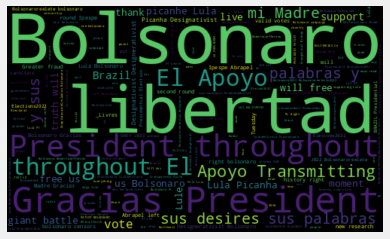

In [261]:
#Check the polarity distribution with Word Cloud for hashtag 1

allWords = " ".join( [twts for twts in df["Tweets"]])
wordCloud = WordCloud(width = 500, height=300, random_state = 42, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")

plt.axis("off")
plt.show()

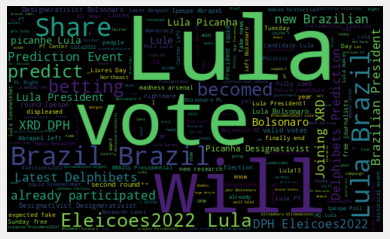

In [262]:
#Check the polarity distribution with Word Cloud for hashtag 2

allWords2 = " ".join( [twts for twts in df2["Tweets"]])
wordCloud2 = WordCloud(width = 500, height=300, random_state = 42, max_font_size = 119).generate(allWords2)

plt.imshow(wordCloud2, interpolation = "bilinear")

plt.axis("off")
plt.show()

In [263]:
#Count values df1

df["Prediction"].value_counts()

POSITIVE    838
NEGATIVE    162
Name: Prediction, dtype: int64

In [264]:
#Describe df1

df["Prediction"].describe()

count         1000
unique           2
top       POSITIVE
freq           838
Name: Prediction, dtype: object

In [265]:
#Show only positive from df1

df[df["Prediction"]=="POSITIVE"]

,Tweets,Prediction
0,: ¡Gracias President throughout El Apoyo! Tran...,POSITIVE
1,: Lord I Ask You to Help The Brazilian People....,POSITIVE
2,: I thank you all for the support at this mome...,POSITIVE
3,22 Bolsonaro,POSITIVE
4,: I thank you all for the support at this mome...,POSITIVE
...,...,...
995,What is Bolsonaro's goal of having a communica...,POSITIVE
996,: Greater fraud in history! right bolsonaro ce...,POSITIVE
997,Paulo Guedes Minister of Economics of Bolsonar...,POSITIVE
998,: Which state will you vote for ?? \n Datapovo...,POSITIVE


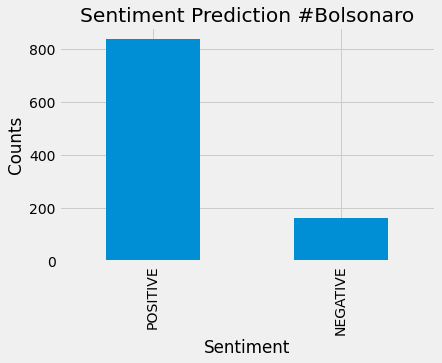

In [266]:
#Let's plot the predictions for the hashtags 

df["Prediction"].value_counts()

#plot

plt.title("Sentiment Prediction " + str(keywords))
plt.xlabel("Sentiment")
plt.ylabel("Counts")
df["Prediction"].value_counts().plot(kind="bar")
plt.show()

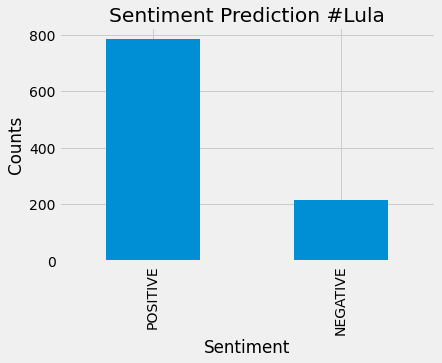

In [267]:
#Let's plot the predictions for the hashtags 

df2["Prediction2"].value_counts()

#plot

plt.title("Sentiment Prediction " + str(keywords2))
plt.xlabel("Sentiment")
plt.ylabel("Counts")
df2["Prediction2"].value_counts().plot(kind="bar")
plt.show()

In [268]:
#Percentage of Positive tweets 

ptweets = df[df.Prediction == "POSITIVE"] 
ptweets = ptweets["Tweets"]
ptweets = (len(ptweets) / len(df)) * 100

ntweets = df[df.Prediction == "NEGATIVE"] 
ntweets = ntweets["Tweets"]
ntweets = (len(ntweets) / len(df)) * 100

ptweets2 = df2[df2.Prediction2 == "POSITIVE"] 
ptweets2 = ptweets2["Tweets"]
ptweets2 = (len(ptweets2) / len(df2)) * 100

ntweets2 = df2[df2.Prediction2 == "NEGATIVE"] 
ntweets2 = ntweets2["Tweets"]
ntweets2 = (len(ntweets2) / len(df2)) * 100



print(str(keywords))
print("Positive " + str(ptweets)+ "%")
print("Negative "+ str(ntweets) + "%")
print("####################")
print(str(keywords2))
print("Positive " + str(ptweets2)+ "%")
print("Negative "+ str(ntweets2) + "%")
print("####################")

#Bolsonaro
Positive 83.8%
Negative 16.2%
####################
#Lula
Positive 78.60000000000001%
Negative 21.4%
####################
